In [4]:
library("tidyverse")
library("infer")
library("moderndive")
library("nycflights13")
library("ggplot2movies")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
promotions |> sample_n(6) |> arrange(id)

id,decision,gender
<int>,<fct>,<fct>
2,promoted,male
10,promoted,male
13,promoted,male
31,promoted,female
35,promoted,female
48,not,female


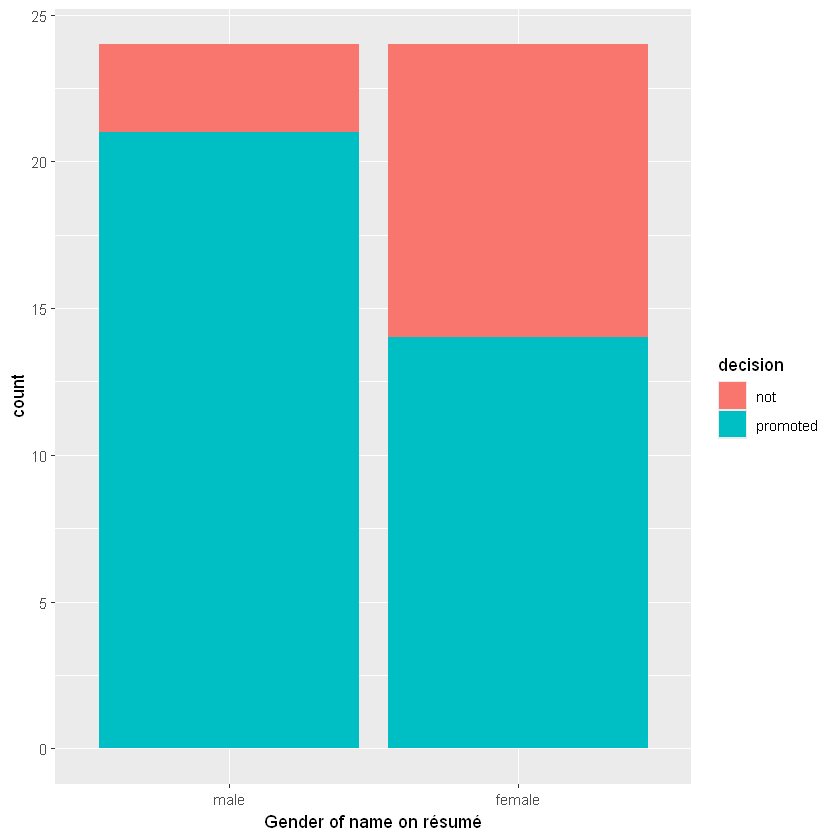

In [6]:
ggplot(promotions, aes(x = gender, fill = decision)) +
  geom_bar() +
  labs(x = "Gender of name on résumé")

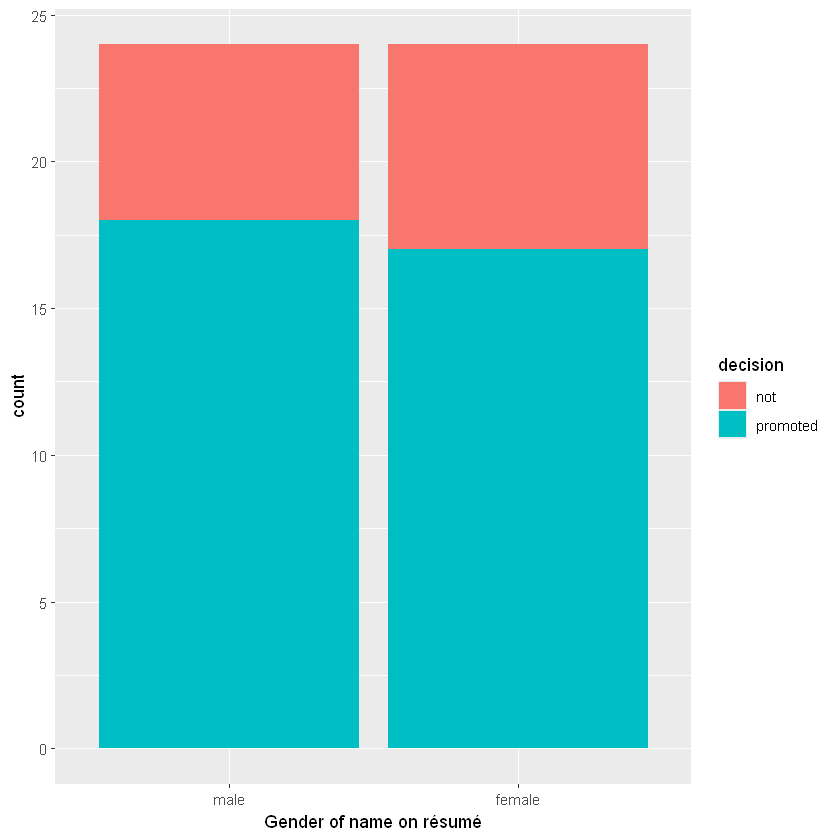

In [7]:
ggplot(promotions_shuffled, aes(x = gender, fill = decision)) +
  geom_bar() +
  labs(x = "Gender of name on résumé")

In [8]:
promotions |> group_by(gender, decision) |> tally()

gender,decision,n
<fct>,<fct>,<int>
male,not,3
male,promoted,21
female,not,10
female,promoted,14


In [9]:
promotions_shuffled |> group_by(gender, decision) |> tally()

gender,decision,n
<fct>,<fct>,<int>
male,not,6
male,promoted,18
female,not,7
female,promoted,17


In [10]:
(21/24*100)
(14/24*100)
(18/24*100)
(17/24*100)
(21/24*100) - (14/24*100)
(18/24*100) - (17/24*100)

[1] 87.5

[1] 58.33333

[1] 75

[1] 70.83333

[1] 29.16667

[1] 4.166667

# Conducting hypothesis tests
<h4>
<ol>
<li><b>specify()</b> the variables of interest in your data frame.</li>
<li><b>hypothesize()</b> the null hypothesis <i>H<sub>0</sub></i>. In other words, set a “model for the universe” assuming <i>H<sub>0</sub></i> is true.</li>
<li><b>generate()</b> shuffles assuming <i>H<sub>0</sub></i> is true. In other words, simulate data assuming <i>H<sub>0</sub></i> is true.</li>
<li><b>calculate()</b> the summary statistic of interest.</li>
<li><b>visualize()</b> the resulting null distribution and compute the p-value by comparing the null distribution to the observed test statistic.</li>
</ol>
</h4>

In [11]:
promotions |>
  specify(formula = decision ~ gender, success = "promoted") |> head()

decision,gender
<fct>,<fct>
promoted,male
promoted,male
promoted,male
promoted,male
promoted,male
promoted,male


In [12]:
promotions |>
  specify(formula = decision ~ gender, success = "promoted") |>
  hypothesize("independence") |> head()

decision,gender
<fct>,<fct>
promoted,male
promoted,male
promoted,male
promoted,male
promoted,male
promoted,male


In [13]:
promotions |>
  specify(formula = decision ~ gender, success = "promoted") |>
  hypothesize("independence") |>
  generate(1000, type = "permute") |> nrow()

[1] 48000

In [14]:
null_distribution <- promotions |>
  specify(formula = decision ~ gender, success = "promoted") |>
  hypothesize("independence") |>
  generate(1000,type = "permute") |>
  calculate(stat = "diff in props", order = c("male", "female"))# ˆp male − ˆp female 
  
null_distribution |> head()

replicate,stat
<int>,<dbl>
1,0.04166667
2,-0.12500000
3,0.20833333
4,0.04166667
5,0.12500000
6,0.04166667


In [15]:
obs_diff_prop <- promotions |>
  specify(formula = decision ~ gender, success = "promoted") |>
  calculate(stat = "diff in props", order = c("male", "female")) # p male − p female

obs_diff_prop

stat
<dbl>
0.2916667


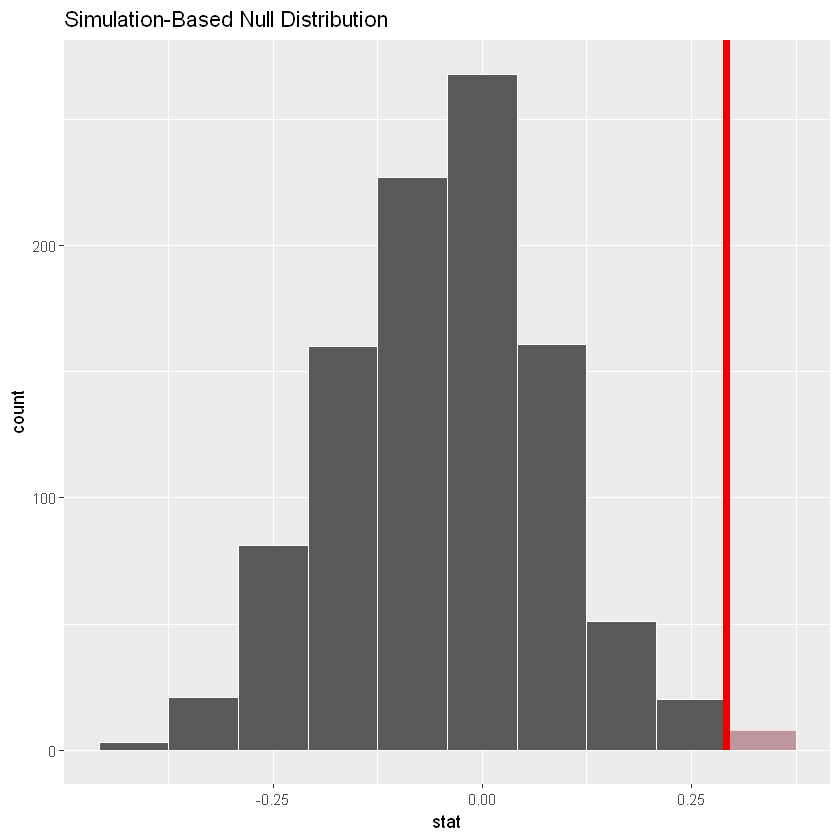

In [16]:
null_distribution |> visualize(bins = 10) +
  shade_p_value(obs_stat = obs_diff_prop, direction = "right")

# Comparison with Confidence Intervals

In [17]:
bootstrap_distribution  <- promotions |>
  specify(formula = decision ~ gender, success = "promoted") |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "diff in props", order = c("male", "female")) # ˆp male − ˆp female 
  
bootstrap_distribution |> head()

replicate,stat
<int>,<dbl>
1,0.3756614
2,0.3285714
3,0.4338624
4,0.2121212
5,0.1777778
6,0.2330435


In [18]:
percentile_ci <- bootstrap_distribution |> get_confidence_interval(level = 0.95, type = "percentile")

percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.06281866,0.5222619


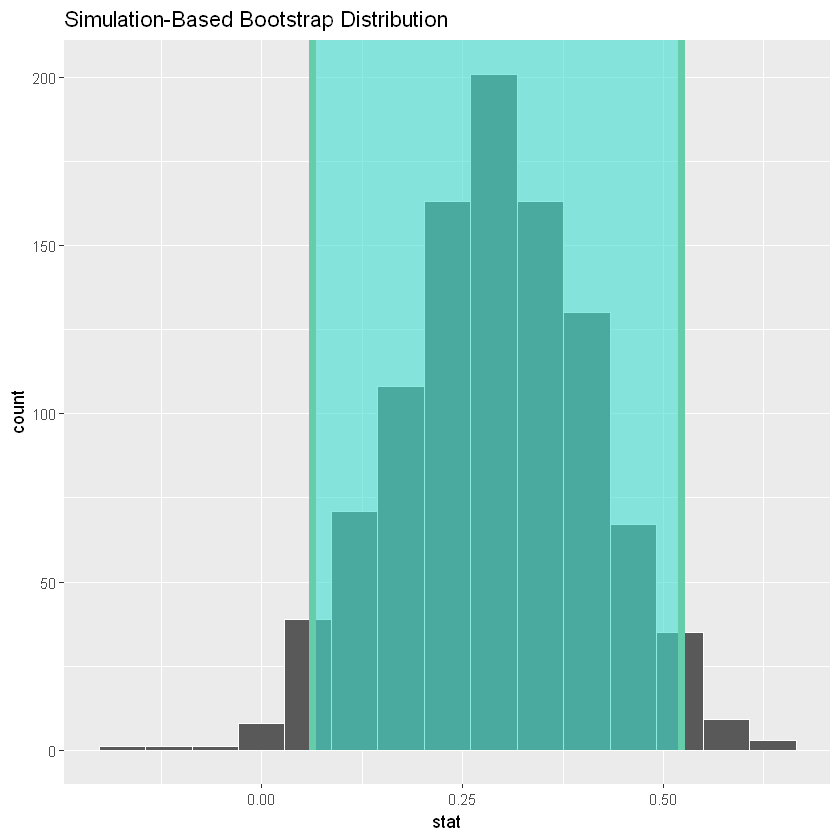

In [19]:
visualize(bootstrap_distribution) + shade_confidence_interval(endpoints = percentile_ci)

<h5>Notice a key value that is not included in the 95% confidence interval for <i>p<sub>m</sub> - p<sub>f</sub></i> : the value 0. In other words, a difference of 0 is not included in our net, suggesting that <i>p<sub>m</sub></i> and <i>p<sub>f</sub></i> are truly different! <br /> Furthermore, observe how the entirety of the 95% confidence interval for <i>p<sub>m</sub> - p<sub>f</sub></i> lies above 0, suggesting that this difference is in favor of men.</h5>

In [20]:
se_ci <- bootstrap_distribution |> get_confidence_interval(level = 0.95, type = "se", point_estimate = obs_diff_prop)

se_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.05572979,0.5276035


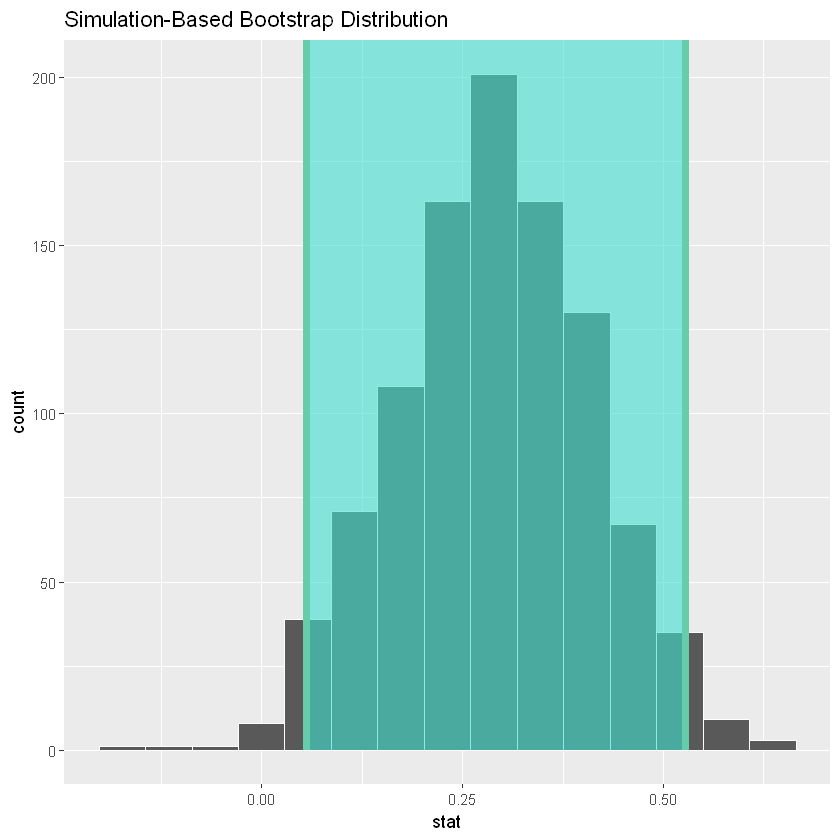

In [21]:
visualize(bootstrap_distribution) +
  shade_confidence_interval(endpoints = se_ci)

# Interpreting hypothesis tests

1. If the p-value < α, then we reject the null hypothesis H0 in favor of HA.
2. If the p-value >= α, we fail to reject the null hypothesis H0.

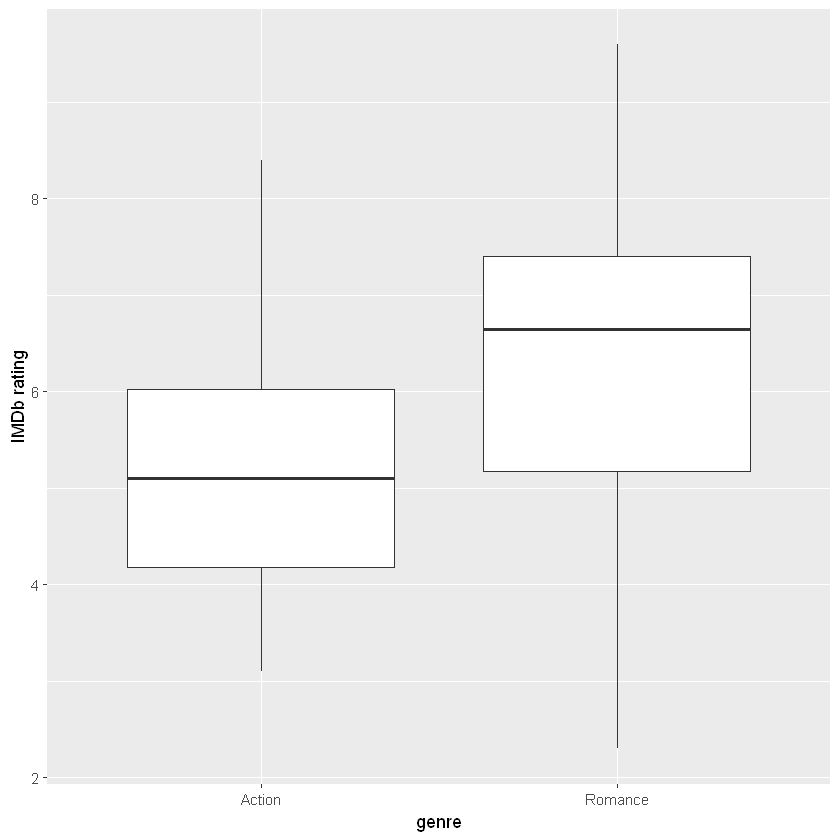

In [22]:
ggplot(data = movies_sample, aes(x = genre, y = rating)) +
  geom_boxplot() +
  labs(y = "IMDb rating")

In [23]:
movies_sample |>
  group_by(genre) |>
  summarize(n = n(), mean_rating = mean(rating), std_dev = sd(rating))

genre,n,mean_rating,std_dev
<chr>,<int>,<dbl>,<dbl>
Action,32,5.275000,1.361214
Romance,36,6.322222,1.609634


In [24]:
null_distribution_movies <- movies_sample |>
  specify(formula = rating ~ genre) |>
  hypothesize(null = "independence") |>
  generate(reps = 5000, type = "permute") |>
  calculate(stat = "diff in means",order = c("Action", "Romance"))

null_distribution_movies |> head()
null_distribution_movies |> tail()

replicate,stat
<int>,<dbl>
1,-0.775694444
2,-0.250347222
3,-0.250347222
4,-0.085069444
5,-0.008333333
6,0.168750000


replicate,stat
<int>,<dbl>
4995,-0.3506944
4996,-0.6399306
4997,-1.2006944
4998,0.2986111
4999,0.1274306
5000,0.2395833


In [25]:
obs_diff_means <- movies_sample |>
  specify(formula = rating ~ genre) |>
  calculate(stat = "diff in means", order = c("Action", "Romance"))

obs_diff_means

stat
<dbl>
-1.047222


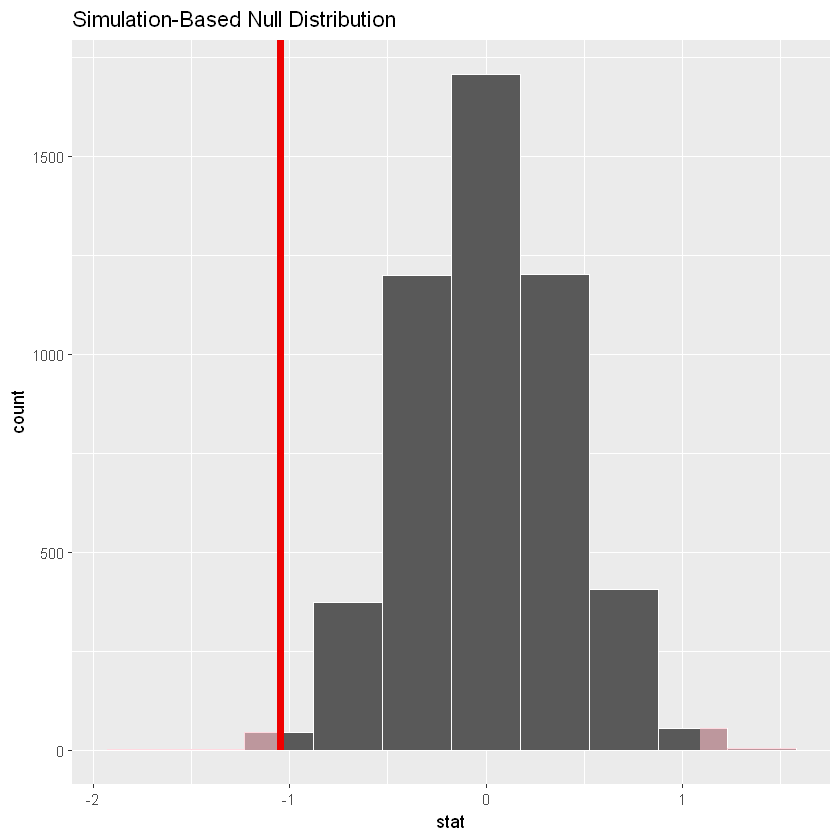

In [26]:
null_distribution_movies |> visualize(bins = 10) +
  shade_p_value(obs_stat = obs_diff_means, direction = "both")

In [27]:
null_distribution_movies |> get_p_value(obs_stat = obs_diff_means, direction = "both")

p_value
<dbl>
0.0036


<h5>This p-value of 0.004 is very small. In other words, there is a very small chance that we’d observe a difference of 5.275 - 6.322 = -1.047 in a hypothesized universe where there was truly no difference in ratings.

But this p-value is larger than our (even smaller) pre-specified α significance level of 0.001. Thus, we are inclined to fail to reject the null hypothesis H0: μa − μr = 0.</h5>